In [1]:
from binance import Client

In [2]:
import numpy as np
import pandas as pd
import ta

In [3]:
client = Client()

In [4]:
def getdaydata(symbol, interval, lookback):
    frame = pd.DataFrame(client.get_historical_klines(symbol, interval, lookback + ' day ago UTC'))
    frame = frame.iloc[:,:6]
    frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    frame = frame.set_index('Time')
    frame.index = pd.to_datetime(frame.index, unit='ms')
    frame = frame.astype(float)
    return frame

In [5]:
df = getdaydata('AVAXUSDT', '5m', '10')

In [6]:
df['%K'] = ta.momentum.stoch(df.High, df.Low, df.Close, window=14, smooth_window=3)

In [7]:
df['%D'] = df['%K'].rolling(3).mean()

In [8]:
df['rsi'] = ta.momentum.rsi(df.Close, window=14)

In [9]:
df['macd'] = ta.trend.macd_diff(df.Close)

In [10]:
df.dropna(inplace=True)

In [11]:
def gettriggers(df, lags, buy=True):
    dfx = pd.DataFrame()
    for i in range(1, lags+1):
        if buy:
            mask = (df['%K'].shift(i) < 20) & (df['%D'].shift(i) < 20)
        else:
            mask = (df['%K'].shift(i) > 80) & (df['%D'].shift(i) > 80)
        dfx = dfx.append(mask, ignore_index=True)
    return dfx.sum(axis=0)
    

In [12]:
df['Buytrigger'] = np.where(gettriggers(df, 4), 1, 0)

In [13]:
df['Selltrigger'] =  np.where(gettriggers(df, 4, False), 1, 0)

In [14]:
df['Buy'] = np.where((df.Buytrigger) 
                     & (df['%K'].between(20,80)) 
                     & (df['%D'].between(20,80)) 
                     & (df['rsi'] > 50) 
                     & (df.macd > 0), 1, 0)

In [15]:
df['Sell'] = np.where((df.Selltrigger) 
                      & (df['%K'].between(20,80)) 
                      & (df['%D'].between(20,80)) 
                      & (df['rsi'] < 50) 
                      & (df.macd < 0), 1, 0)

In [16]:
Buying_dates, Selling_dates = [], []

In [17]:
for i in range(len(df) - 1):
    if df.Buy.iloc[i]:
        Buying_dates.append(df.iloc[i+1].name)
        for num, j in enumerate(df.Sell[i:]):
            if j:
                Selling_dates.append(df.iloc[i + num + 1].name)
                break

In [18]:
cutit = len(Buying_dates) - len(Selling_dates)

In [19]:
if cutit:
    Buying_dates = Buying_dates[:-cutit]

In [20]:
frame = pd.DataFrame({'Buying_dates': Buying_dates, 'Selling_dates': Selling_dates})

In [21]:
actuals = frame[frame.Buying_dates > frame.Selling_dates.shift(1)]

In [22]:
actuals

,Buying_dates,Selling_dates
2,2021-09-28 20:05:00,2021-09-29 03:05:00
5,2021-09-29 06:40:00,2021-09-29 11:20:00
7,2021-09-29 14:05:00,2021-09-30 04:35:00
9,2021-09-30 21:40:00,2021-10-01 00:20:00
11,2021-10-02 11:45:00,2021-10-02 13:30:00
13,2021-10-03 17:55:00,2021-10-05 01:40:00


In [23]:
def profitcalc():
    Buyprices = df.loc[actuals.Buying_dates].Open
    Sellprices = df.loc[actuals.Selling_dates].Open
    return (Sellprices.values - Buyprices.values)/Buyprices.values

In [24]:
profits = profitcalc()

In [25]:
profits

array([-0.00959119, -0.00766049,  0.04700389,  0.00548697,  0.0037515 ,
       -0.0697408 ])

In [26]:
profits.mean()

-0.005125020193045542

In [27]:
(profits + 1).prod()

0.9661169481525967

In [28]:
import matplotlib.pyplot as plt

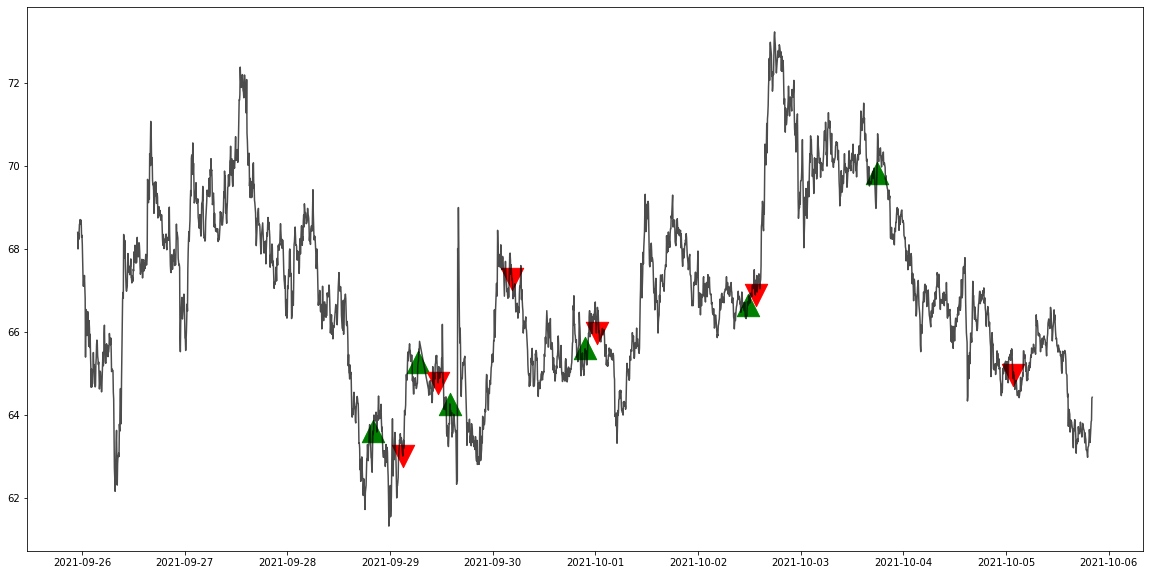

In [29]:
plt.figure(figsize=(20, 10))
plt.plot(df.Close, color='k', alpha=0.7)
plt.scatter(actuals.Buying_dates, df.Open[actuals.Buying_dates], marker='^', color='g', s=500)
plt.scatter(actuals.Selling_dates, df.Open[actuals.Selling_dates], marker='v', color='r', s=500)

In [30]:
(df.Close[0], df.Close[-1])

(68.4, 64.42)